# 2020 US General Election

---

---

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from statsmodels.stats.weightstats import DescrStatsW

import us

import sys

import os
path = os.getcwd()
path = path[:path.find('us_election2020')] + 'us_election2020'

sys.path.append(path + '\\src\\data')
import make_dataset

In [2]:
make_dataset.general_election_polls2020_preprocessig()

In [3]:
make_dataset.president_approval_polls2020_preprocessig()

In [4]:
polls2020 = pd.read_csv(path + '\data\processed\general_election_polls2020.csv', 
                        parse_dates=['start_date', 'end_date', 'created_at'], index_col=['start_date'])

In [5]:
polls2020

,poll_id,question_id,state,pollster_id,pollster,sample_size,population,end_date,created_at,url,Trump,Biden,diff,population_weight,weight
start_date,,,,,,,,,,,,,,,
2018-11-27,57026,92080,Ohio,383,Public Policy Polling,648,v,2018-11-28,2018-12-06 14:43:00,https://www.cleveland.com/politics/2018/11/thi...,44.0,48.0,4.0,0.8,518.4
2018-12-16,57170,92351,National,1416,Harris Insights & Analytics,1001,rv,2018-12-17,2018-12-25 23:57:00,https://thehill.com/hilltv/what-americas-think...,36.0,42.0,6.0,0.9,900.9
2019-01-04,57275,92597,North Carolina,383,Public Policy Polling,750,rv,2019-01-07,2019-01-09 13:09:00,https://www.publicpolicypolling.com/wp-content...,44.0,49.0,5.0,0.9,675.0
2019-01-19,57365,92773,National,383,Public Policy Polling,760,rv,2019-01-21,2019-01-22 13:58:00,https://www.publicpolicypolling.com/wp-content...,41.0,53.0,12.0,0.9,684.0
2019-01-24,57427,92926,Michigan,176,Glengariff Group,600,lv,2019-01-26,2019-01-29 21:17:00,https://www.clickondetroit.com/michigan-politi...,40.3,53.3,13.0,1.0,600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-14,68123,127611,National,744,Ipsos,1179,rv,2020-08-18,2020-08-19 16:55:00,https://www.ipsos.com/sites/default/files/ct/n...,40.0,48.0,8.0,0.9,1061.1
2020-08-14,68136,127628,National,1302,Echelon Insights,1000,lv,2020-08-18,2020-08-20 12:05:00,https://60p3co1nax34ovc830mr2sak-wpengine.netd...,39.0,53.0,14.0,1.0,1000.0
2020-08-15,68141,127636,New Hampshire,446,Saint Anselm College,1042,rv,2020-08-17,2020-08-20 17:26:00,https://htv-prod-media.s3.amazonaws.com/files/...,43.0,51.0,8.0,0.9,937.8


---

---

---

In [6]:
def get_state_stats_atK(df, candidates, state, k):
    """
    Get candidate's average and standard deviation (weighted) in state
    INPUT:
    - df: dataframe with polls statistics
    - candidates: list of candidates to return stats
    - state: US state
    - k: last k polls to analyse
    
    OUTPUT:
    - df with candidates avg, diff avd, and std
    """
    
    candidates = candidates + ['diff']
    cols_avg = [c + '_avg' for c in candidates]
    cols_std = [c + '_std' for c in candidates]

    df = df[df['state'] == state]
    df = df[candidates + ['pollster_id', 'weight']]
    
    df = df['2019-06':]

    start = str(df.index.min().date())
    end = str(datetime.today().date())

    index_stats_df = pd.date_range(start=start, end=end, freq='D')
    cols_stats_df = cols_avg + cols_std
    state_stats_df = pd.DataFrame(index=index_stats_df, columns=cols_stats_df)
        
    for day in index_stats_df:
        atK_df = df.loc[:day].tail(k)
        
        
        if atK_df.shape[0] == 1:
            state_stats_df.loc[day, cols_avg] = atK_df[candidates].values[0]
            state_stats_df.loc[day, cols_std] = np.nan
        elif atK_df.shape[0] > 1:
            weighted_stats = DescrStatsW(atK_df[candidates], weights=atK_df[['weight']], ddof=0)  
            try:
                state_stats_df.loc[day, cols_avg] = weighted_stats.mean.reshape(-1,)
                state_stats_df.loc[day, cols_std] = weighted_stats.std.reshape(-1,)
            except: pass


    state_stats_df = state_stats_df.dropna(axis='rows', how='all').astype(float)
    
    return state_stats_df

In [93]:
def get_state_statsSmooth_atK(df, candidates, state, k):
    """
    Get candidate's average and standard deviation (weighted) in state
    INPUT:
    - df: dataframe with polls statistics
    - candidates: list of candidates to return stats
    - state: US state
    - k: last k polls to analyse
    
    OUTPUT:
    - df with candidates avg, diff avd, and std
    """
    
    candidates = candidates + ['diff']
    cols_avg = [c + '_avg' for c in candidates]
    cols_std = [c + '_std' for c in candidates]
    cols_wgt = []

    df = df[df['state'] == state]
    df = df[candidates + ['pollster_id', 'weight']]

    start = str(df.index.min().date())
    end = str(datetime.today().date())

    index_stats_df = pd.date_range(start=start, end=end, freq='D')
    cols_stats_df = cols_avg + cols_std
    state_stats_df = pd.DataFrame(index=index_stats_df, columns=cols_stats_df)
    
    df['weight'] = (df[['weight']])**(1/4) + 1
    
    for day in index_stats_df:
        atK_df = df.loc[:day].tail(k)
        
        atK_pollsTimes = atK_df.groupby('pollster_id').count()[['weight']].rename(columns={'weight':'times'}).reset_index()
        atK_df = atK_df.merge(atK_pollsTimes, on='pollster_id')
        atK_df['weight'] = atK_df['weight']/(atK_df['times']) + 1
        
        if atK_df.shape[0] == 1:
            state_stats_df.loc[day, cols_avg] = atK_df[candidates].values[0]
            state_stats_df.loc[day, cols_std] = np.nan
            
        elif atK_df.shape[0] > 1:
            
            for cand in candidates:
                atK_df['weight_'+cand] = atK_df['weight']
            
            if state_stats_df.dropna().shape[0] > 10:
                atK_df[['weight_'+candidates[0], 'weight_'+candidates[1], 'weight_diff']] /= (1+(np.abs((atK_df[candidates] - state_stats_df[cols_avg].dropna().iloc[-1].values)/state_stats_df[cols_std].dropna().iloc[-1].values) + 1).values**(2))

            weighted_stats_cand0 = DescrStatsW(atK_df[candidates[0]], weights=atK_df['weight_'+candidates[0]], ddof=0)
            weighted_stats_cand1 = DescrStatsW(atK_df[candidates[1]], weights=atK_df['weight_'+candidates[1]], ddof=0)
            weighted_stats_diff = DescrStatsW(atK_df['diff'], weights=atK_df[['weight_diff']], ddof=0)     
            if day.date() == pd.to_datetime('2019-12-27').date():
                atK_df.to_csv('ver.csv')
            try:

                state_stats_df.loc[day, [cols_avg[0]]] = weighted_stats_cand0.mean.reshape(-1,)
                state_stats_df.loc[day, [cols_std[0]]] = weighted_stats_cand0.std.reshape(-1,)
                state_stats_df.loc[day, [cols_avg[1]]] = weighted_stats_cand1.mean.reshape(-1,)
                state_stats_df.loc[day, [cols_std[1]]] = weighted_stats_cand1.std.reshape(-1,)
                state_stats_df.loc[day, [cols_avg[2]]] = weighted_stats_diff.mean.reshape(-1,)
                state_stats_df.loc[day, [cols_std[2]]] = weighted_stats_diff.std.reshape(-1,)
            except: pass


    state_stats_df = state_stats_df.dropna(axis='rows', how='all').astype(float)
    
    return state_stats_df

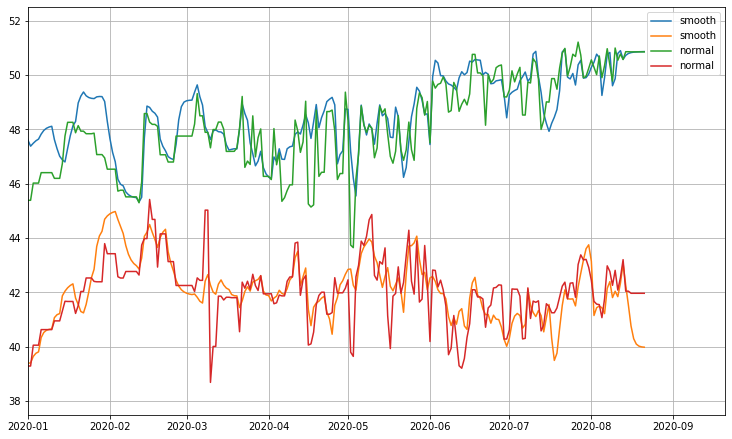

In [94]:
plt.figure(figsize=(12.5, 7.5))
plt.plot(get_state_statsSmooth_atK(polls2020, candidates=['Biden', 'Trump'], state='National', k=5)[['Biden_avg', 'Trump_avg']], label='smooth')
plt.plot(get_state_stats_atK(polls2020, candidates=['Biden', 'Trump'], state='National', k=5)[['Biden_avg', 'Trump_avg']], label='normal')

plt.legend()
plt.grid()
plt.xlim(xmin=pd.to_datetime('2020-01-01'))
plt.ylim(37.5, 52.5)
plt.show()
#get_table_atK(polls2020, 'National', k=10)

In [8]:
get_state_stats_atK(pr_approval_polls2020, state='National', k=30, candidates=['approve', 'disapprove'])

NameError: name 'pr_approval_polls2020' is not defined

In [9]:
get_polls_plot_atK(polls2020, 'National', 20, election=2020)
get_table_atK(polls2020, 'National', k=10)

NameError: name 'get_polls_plot_atK' is not defined

In [18]:
z= get_state_stats_atK(polls2020, candidates=['Biden', 'Trump'], state='National', k=20)
z

,Biden_avg,Trump_avg,diff_avg,Biden_std,Trump_std,diff_std
2019-06-03,47.800000,43.700000,4.100000,NaN,NaN,NaN
2019-06-04,47.800000,43.700000,4.100000,NaN,NaN,NaN
2019-06-05,47.800000,43.700000,4.100000,NaN,NaN,NaN
2019-06-06,50.278199,41.936666,8.341534,2.597145,1.847969,4.445114
2019-06-07,47.523907,38.016085,9.507822,3.673130,4.645726,3.582027
...,...,...,...,...,...,...
2020-08-16,50.663486,42.277870,8.385615,1.327279,1.298269,1.525165
2020-08-17,50.663486,42.277870,8.385615,1.327279,1.298269,1.525165
2020-08-18,50.663486,42.277870,8.385615,1.327279,1.298269,1.525165
2020-08-19,50.663486,42.277870,8.385615,1.327279,1.298269,1.525165


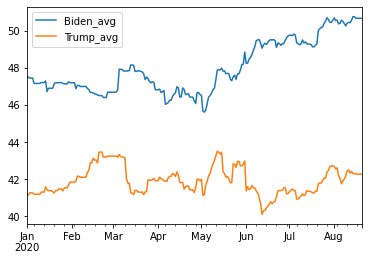

In [19]:
z.iloc[:, :2].loc['2020':].plot()

In [20]:
def get_table_atK(df, state, k, election=2020):
    """
    Get table with last k polls in the state with sample size and type of respondents (population)
    INPUT:
    - df: dataframe with polls statistics
    - candidates: list of candidates to return stats
    - state: US state
    - k: last k polls to analyse
    
    OUTPUT:
    - df with candidates avg, diff avd, and std
    """
    
    df = df[df['state'] == state]
    df = df.reset_index()
    df = df.reset_index().set_index(['start_date', 'end_date', 'pollster', 'population', 'sample_size'])
    if election == 2020:
        candidates = ['Biden', 'Trump']
    elif election == 2016:
        candidates = ['Clinton', 'Trump']
    df = df[candidates].tail(k).sort_index(level=['start_date', 'end_date'], ascending=[False, False])
    
    return df

In [21]:
def get_polls_plot_atK(df, state, k, election=2020):
    """
    Plot graphs
    INPUT:
    - df: dataframe with polls statistics
    - state: US state
    - k: last k polls to analyse
    - election: 2016, 2020, or pr_approval
    
    OUTPUT:
    - plot
    """
    if election == 'pr_approval':
        candidates = ['approve', 'disapprove']
        candidates_color = {'approve':'darkorange', 'disapprove':'darkgreen'}
    if election == 2020:
        candidates = ['Biden', 'Trump']
        candidates_color = {'Biden':'blue', 'Trump':'red'}
    elif election == 2016:
        candidates = ['Clinton', 'Trump']
        candidates_color = {'Clinton':'blue', 'Trump':'red'}
    
    state_polls2020 = df[df['state'] == state]
    state_stats_k = get_state_stats_atK(df, candidates=candidates, state=state, k=k)

    plt.figure(figsize=(15, 7.5))
    
    for candidate in candidates:
        plt.scatter(state_polls2020.index, state_polls2020[candidate], color=candidates_color[candidate], s=2.5)
        plt.plot(state_stats_k[candidate+'_avg'], color=candidates_color[candidate], lw=1.5, label=candidate)
        
        plt.text(x=state_stats_k[candidate+'_avg'].index[-1] + timedelta(days=2.5),
                 y=state_stats_k[candidate+'_avg'].iloc[-1], fontsize=12.5,
                 s=str(round(state_stats_k[candidate+'_avg'].iloc[-1], 1)), color=candidates_color[candidate])


        plt.fill_between(state_stats_k[candidate+'_avg'].index,
                         state_stats_k[candidate+'_avg']+1.5*state_stats_k[candidate+'_std'],
                         state_stats_k[candidate+'_avg']-1.5*state_stats_k[candidate+'_std'],
                         alpha=0.1, color=candidates_color[candidate])
        plt.fill_between(state_stats_k[candidate+'_avg'].index,
                         state_stats_k[candidate+'_avg']+state_stats_k[candidate+'_std'],
                         state_stats_k[candidate+'_avg']-state_stats_k[candidate+'_std'],
                         alpha=0.2, color=candidates_color[candidate])

    plt.legend()
    if election == 'pr_approval': 
        plt.xlim(xmin=datetime(2019, 1, 1), xmax=state_polls2020.index.max() + timedelta(days=21))
        plt.ylim((30, 65))
        plt.title('2020 US General Election - Trump Job Approval', fontsize=15)
        plt.grid(ls='--', alpha=0.5)
        plt.tight_layout()
        plt.savefig(path+'\\reports\\figures\\2020_US_Genereal_Election-TrumpJobApproval.png')
    else: 
        plt.xlim(xmin=datetime(2020, 1, 1), xmax=state_polls2020.index.max() + timedelta(days=21))
        plt.ylim((35, 55))
        plt.title('2020 US General Election - '+state, fontsize=15)
        plt.grid(ls='--', alpha=0.5)
        plt.tight_layout()
        plt.savefig(path+'\\reports\\figures\\2020_US_Genereal_Election-'+state+'-polls.png')

    plt.show()

---

---

---

# National Report

## 1. who leads the National preference to be the US next president?

---

In [22]:
national_polls2020 = polls2020[polls2020['state'] == 'National']
national_stats_k10 = get_state_stats_atK(polls2020, candidates=['Biden', 'Trump'], state='National', k=10)

national_stats_k5 = get_state_stats_atK(polls2020, candidates=['Biden', 'Trump'], state='National', k=5)

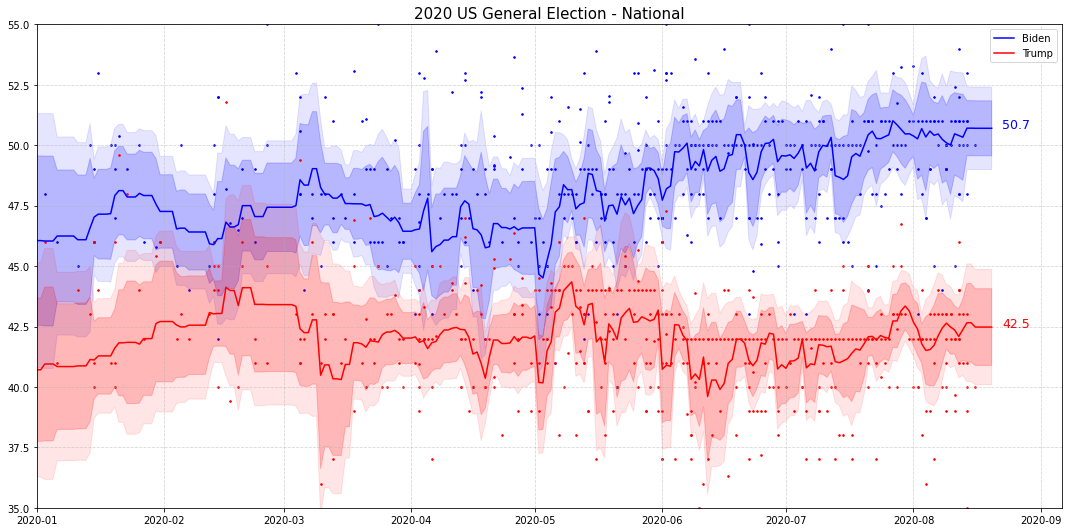

Biden  \
start_date end_date   pollster                                 population sample_size          
2020-08-16 2020-08-18 YouGov                                   rv         1246          50.0   
2020-08-14 2020-08-18 Ipsos                                    rv         1179          48.0   
                      Echelon Insights                         lv         1000          53.0   
           2020-08-16 Léger                                    a          1001          51.0   
                      Morning Consult                          lv         11809         51.0   
           2020-08-15 YouGov                                   lv         1027          50.0   
2020-08-13 2020-08-15 Morning Consult                          lv         12000         51.0   
           2020-08-14 Data for Progress                        lv         1143          50.0   
2020-08-12 2020-08-18 Rasmussen Reports/Pulse Opinion Research lv         2500          48.0   
           2020-08-15 ABC News/The Washington Post             lv         707           54.0   

                                                                                       Trump  
start_date end_date   pollster                                 population sample_size         
2020-08-16 2020-08-18 YouGov                                   rv         1246          40.0  
2020-08-14 2020-08-18 Ipsos                                    rv         1179          40.0  
                      Echelon Insights                         lv         1000          39.0  
           2020-08-16 Léger                                    a          1001          35.0  
                      Morning Consult                          lv         11809         43.0  
           2020-08-15 YouGov                                   lv         1027          41.0  
2020-08-13 2020-08-15 Morning Consult                          lv         12000         43.0  
           2020-08-14 Data for Progress                        lv         1143          41.0  
2020-08-12 2020-08-18 Rasmussen Reports/Pulse Opinion Research lv         2500          44.0  
           2020-08-15 ABC News/The Washington Post             lv         707           44.0

In [23]:
get_polls_plot_atK(polls2020, 'National', 10, election=2020)
get_table_atK(polls2020, 'National', k=10)

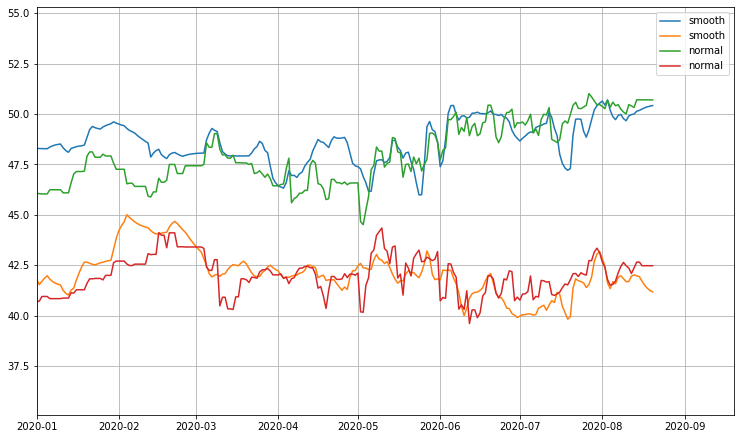

In [60]:
plt.figure(figsize=(12.5, 7.5))
plt.plot(get_state_statsSmooth_atK(polls2020, candidates=['Biden', 'Trump'], state='National', k=10)[['Biden_avg', 'Trump_avg']], label='smooth')
plt.plot(get_state_stats_atK(polls2020, candidates=['Biden', 'Trump'], state='National', k=10)[['Biden_avg', 'Trump_avg']], label='normal')

plt.legend()
plt.grid()
plt.xlim(xmin=pd.to_datetime('2020-01-01'))
plt.show()
#get_table_atK(polls2020, 'National', k=10)

---

---

---

In [25]:
def get_states_diff_distribution(df, k, election=2020, on_day=str(datetime.today().date())):
    """
    Get difference distribution between candidates (Democrat - Republica) per state
    INPUT:
    - df: dataframe with polls statistics
    - state: US state
    - k: last k polls to analyse
    - on_day: difference between candidates on day
    
    OUTPUT:
    - df with last_poll avg date, candidate avg, and difference between candidates
    """
    
    if election == 2020:
        candidates = ['Biden', 'Trump']
    elif election == 2016:
        candidates = ['Clinton', 'Trump']
        on_day= '2016' + str(datetime.today().date())[4:]
        
    df = df.loc[:on_day]

    columns = [c +  '_avg' for c in candidates + ['diff']]
    expected_college = pd.DataFrame(index=list(us.states.mapping('abbr', 'name', states=us.states.STATES).values()), 
                                    columns=columns)

    for state in expected_college.index:
        state = str(state)
        print(state, end='                    \r')
        state_df = df[df['state'] == state].tail(k)
        try:
            state_stats_k = get_state_stats_atK(state_df, candidates=candidates, state=state, k=k)
            expected_college.loc[state, 'last_poll'] = state_df.index.max()
            expected_college.loc[state, columns] = state_stats_k[columns].iloc[-1]
        except: pass
        
    us_college =  pd.read_csv(path+'\\data\\external\\us_college.csv', index_col='state')
        
    expected_college = expected_college[['last_poll'] + columns]
    
    expected_college = us_college.join(expected_college)
    expected_college[columns] = round(expected_college[columns].astype(float), 2)
    expected_college = expected_college.sort_values('diff_avg')
    
    return expected_college

In [26]:
get_states_diff_distribution(polls2020, k=20, election=2020, on_day=str(datetime.today().date()))

,electoral_college,last_poll,Biden_avg,Trump_avg,diff_avg
state,,,,,
West Virginia,5,2020-01-07,31.00,66.00,-35.00
Oklahoma,7,2020-07-29,34.81,57.34,-22.52
North Dakota,3,2020-03-03,36.45,57.54,-21.09
Alabama,9,2020-07-24,38.25,56.55,-18.31
Kentucky,8,2020-07-30,38.33,54.54,-16.21
Utah,6,2020-07-27,34.86,48.49,-13.63
Indiana,11,2020-07-24,38.68,52.01,-13.33
Tennessee,11,2020-05-05,39.55,52.66,-13.12
Mississippi,6,2020-07-30,40.78,52.12,-11.34


In [27]:
def get_election_results():
    """
    Get difference distribution between candidates (Democrat - Republica) per state
    INPUT:
    - df: dataframe with polls statistics
    - state: US state
    - k: last k polls to analyse
    - on_day: difference between candidates on day
    
    OUTPUT:
    - df with candidates avg, diff avd, and std
    """
    
    us_election_results = pd.read_csv(path+'\\data\\external\\us_election_results.csv', 
                                      header=[0,1], index_col=0)
    
    us_election_results[('2016', 'result')] = us_election_results['2016']['Clinton'] - us_election_results['2016']['Trump']
    us_election_results[('2012', 'result')] = us_election_results['2012']['Obama'] - us_election_results['2012']['Romney']
    us_election_results[('2008', 'result')] = us_election_results['2012']['Obama'] - us_election_results['2008']['Mccain']
    
    us_election_results.columns = [(col[1]+'_'+col[0]) for col in us_election_results.columns]
    return us_election_results

In [28]:
def get_expected_electoral_college(df, k, election=2020, on_day=str(datetime.today().date())):
    """
    Get full df with last poll data avg, candidates avg, 2008-2016 General Election Results and 
    cumulate electoral college for Democrat and Republican candidates
    INPUT:
    - df: dataframe with polls statistics
    - k: last k polls to analyse
    - on_day: difference between candidates on day
    
    OUTPUT:
    - df
    """
    
    states_diff_distribution = get_states_diff_distribution(df, k=k, election=election, on_day=on_day)
    us_election_results = get_election_results()
    
    states_diff_distribution = states_diff_distribution.join(us_election_results)
    
    states_diff_distribution.loc[states_diff_distribution['last_poll'].isna(), 'diff_avg'] = states_diff_distribution.loc[states_diff_distribution['last_poll'].isna(), 'result_2016']
    states_diff_distribution = states_diff_distribution.sort_values('diff_avg')
    
    states_diff_distribution.loc[states_diff_distribution['diff_avg'] < 0., 'cum_electoral_college'] = states_diff_distribution.loc[states_diff_distribution['diff_avg'] < 0., 'electoral_college'].cumsum()
    states_diff_distribution.loc[states_diff_distribution['diff_avg'] > 0., 'cum_electoral_college'] = states_diff_distribution.loc[states_diff_distribution['diff_avg'] > 0., 'electoral_college'][::-1].cumsum()[::-1]
    
    return states_diff_distribution

# States report
## 2. how US states are leaned to vote?
---

In [29]:
expected_electoral_college2020 = get_expected_electoral_college(polls2020, k=10, election=2020, on_day=str(datetime.today().date()))

In [30]:
expected_electoral_college2020

,electoral_college,last_poll,Biden_avg,Trump_avg,diff_avg,Clinton_2016,Trump_2016,Obama_2012,Romney_2012,Obama_2008,Mccain_2008,Kerry_2004,Bush_2004,result_2016,result_2012,result_2008,cum_electoral_college
state,,,,,,,,,,,,,,,,,
Wyoming,3,NaT,NaN,NaN,-46.29,21.88,68.17,27.82,68.64,32.54,64.78,29.07,68.86,-46.29,-40.82,-36.96,3.0
West Virginia,5,2020-01-07,31.00,66.00,-35.00,26.43,68.50,35.54,62.30,42.59,55.71,43.20,56.06,-42.07,-26.76,-20.17,8.0
Idaho,4,NaT,NaN,NaN,-31.77,27.49,59.26,32.62,64.53,36.10,61.53,30.26,68.38,-31.77,-31.91,-28.91,12.0
South Dakota,3,NaT,NaN,NaN,-29.79,31.74,61.53,39.87,57.89,44.75,53.16,38.44,59.91,-29.79,-18.02,-13.29,15.0
Oklahoma,7,2020-07-29,34.81,57.34,-22.52,28.93,65.32,33.23,66.77,34.35,65.65,34.43,65.57,-36.39,-33.54,-32.42,22.0
North Dakota,3,2020-03-03,36.45,57.54,-21.09,27.23,62.96,38.69,58.32,44.62,53.25,35.50,62.86,-35.73,-19.63,-14.56,25.0
Alabama,9,2020-07-24,38.25,56.55,-18.31,34.36,62.08,38.36,60.55,38.74,60.32,36.84,62.46,-27.72,-22.19,-21.96,34.0
Kentucky,8,2020-07-30,38.41,54.39,-15.98,32.68,62.52,37.80,60.49,41.17,57.40,39.69,59.55,-29.84,-22.69,-19.60,42.0
Utah,6,2020-07-27,34.86,48.49,-13.63,27.46,45.54,24.75,72.79,34.41,62.58,26.00,71.54,-18.08,-48.04,-37.83,48.0


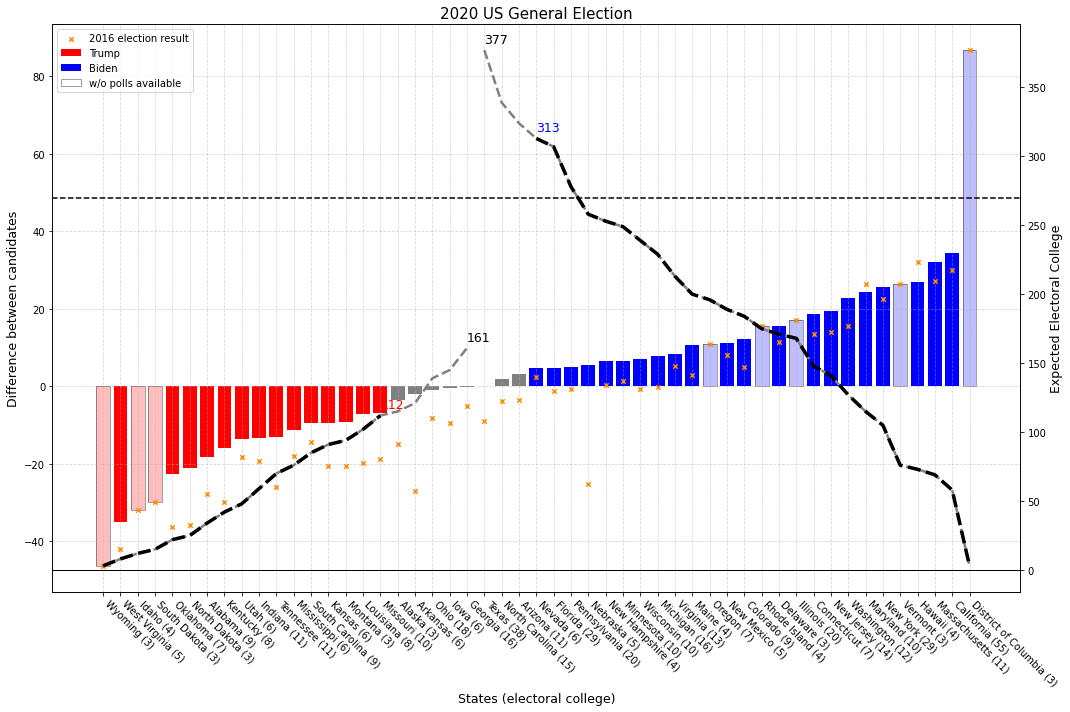

In [31]:
trump_index = expected_electoral_college2020['diff_avg'] < -4.
biden_index = expected_electoral_college2020['diff_avg'] > 4.
pro_trump_index = expected_electoral_college2020['diff_avg'] < 0.
pro_biden_index = expected_electoral_college2020['diff_avg'] > 0.

no_polls_index = expected_electoral_college2020['last_poll'].isna()

fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()

ax1.scatter(x=expected_electoral_college2020.index, y=expected_electoral_college2020['result_2016'], 
            color='darkorange', s=20., marker='x', zorder=5, label='2016 election result')

ax2.plot(expected_electoral_college2020['cum_electoral_college'].loc[pro_trump_index], 
         lw=2.5, ls='--', color='gray')
ax2.plot(expected_electoral_college2020['cum_electoral_college'].loc[trump_index], 
         lw=3.5, ls='--', color='black')
ax2.plot(expected_electoral_college2020['cum_electoral_college'].loc[pro_biden_index], 
         lw=2.5, ls='--', color='gray')
ax2.plot(expected_electoral_college2020['cum_electoral_college'].loc[biden_index], 
         lw=3.5, ls='--', color='black')

ax2.text(x=expected_electoral_college2020['cum_electoral_college'].loc[pro_trump_index].iloc[[-1]].index, 
         y=expected_electoral_college2020['cum_electoral_college'].loc[pro_trump_index].iloc[-1] + 5, 
         s=str(int(expected_electoral_college2020['cum_electoral_college'].loc[pro_trump_index].iloc[-1])), 
         color='black', fontsize=12.5)
ax2.text(x=expected_electoral_college2020['cum_electoral_college'].loc[pro_biden_index].iloc[[0]].index, 
         y=expected_electoral_college2020['cum_electoral_college'].loc[pro_biden_index].iloc[0] + 5, 
         s=str(int(expected_electoral_college2020['cum_electoral_college'].loc[pro_biden_index].iloc[0])), 
         color='black', fontsize=12.5)
ax2.text(x=expected_electoral_college2020['cum_electoral_college'].loc[trump_index].iloc[[-1]].index, 
         y=expected_electoral_college2020['cum_electoral_college'].loc[trump_index].iloc[-1] + 5, 
         s=str(int(expected_electoral_college2020['cum_electoral_college'].loc[trump_index].iloc[-1])), 
         color='red', fontsize=12.5)
ax2.text(x=expected_electoral_college2020['cum_electoral_college'].loc[biden_index].iloc[[0]].index, 
         y=expected_electoral_college2020['cum_electoral_college'].loc[biden_index].iloc[0] + 5, 
         s=str(int(expected_electoral_college2020['cum_electoral_college'].loc[biden_index].iloc[0])), 
         color='blue', fontsize=12.5)

ax1.bar(x=expected_electoral_college2020.index, 
        height=expected_electoral_college2020['diff_avg'], 
        color='gray')
ax1.bar(x=expected_electoral_college2020.loc[trump_index].index, 
        height=expected_electoral_college2020['diff_avg'].loc[trump_index], 
        color='red', label='Trump')
ax1.bar(x=expected_electoral_college2020.loc[biden_index].index, 
        height=expected_electoral_college2020['diff_avg'].loc[biden_index], 
        color='blue', label='Biden')
ax1.bar(x=expected_electoral_college2020.loc[no_polls_index].index, 
        height=expected_electoral_college2020['diff_avg'].loc[no_polls_index], 
        color='white', edgecolor='gray', alpha=0.75, label='w/o polls available')

ax2.axhline(0, color='black', lw=1.)
ax2.axhline(270, color='black', lw=1.5, ls='--')

ax1.legend()
xlabel = [label[0] + ' ('+str(label[1])+')' for label in 
          zip(expected_electoral_college2020['electoral_college'].index, 
                expected_electoral_college2020['electoral_college'].values)]
ax1.set_xticklabels(xlabel, rotation=-45, ha='left')
ax1.grid(axis='both', ls='--', alpha=0.5)
plt.title('2020 US General Election', fontsize=15)
ax1.set_ylabel('Difference between candidates', fontsize=12.5)
ax2.set_ylabel('Expected Electoral College', fontsize=12.5)
ax1.set_xlabel('States (electoral college)', fontsize=12.5)
plt.tight_layout()
plt.savefig(path+'\\reports\\figures\\2020_US_Genereal_Election-expected_college.png')
plt.show()

### Swing States
#### EX: Texas and Florida
---

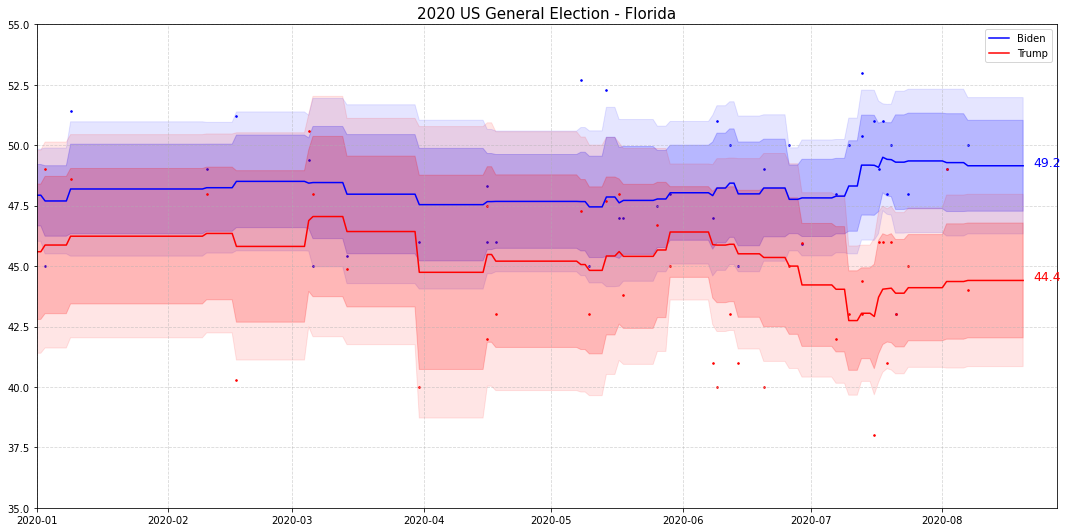

,,,,,Biden,Trump
start_date,end_date,pollster,population,sample_size,,
2020-08-07,2020-08-09,Change Research,lv,469,50.0,44.0
2020-08-02,2020-08-04,OnMessage Inc.,lv,400,49.0,49.0
2020-07-24,2020-07-26,Change Research,lv,685,48.0,45.0
2020-07-21,2020-07-23,Zogby Interactive/JZ Analytics,lv,811,43.0,43.0
2020-07-20,2020-07-23,Mason-Dixon Polling & Strategy,lv,625,50.0,46.0


In [32]:
get_polls_plot_atK(polls2020, 'Florida', 10, election=2020)
get_table_atK(polls2020, 'Florida', k=5)

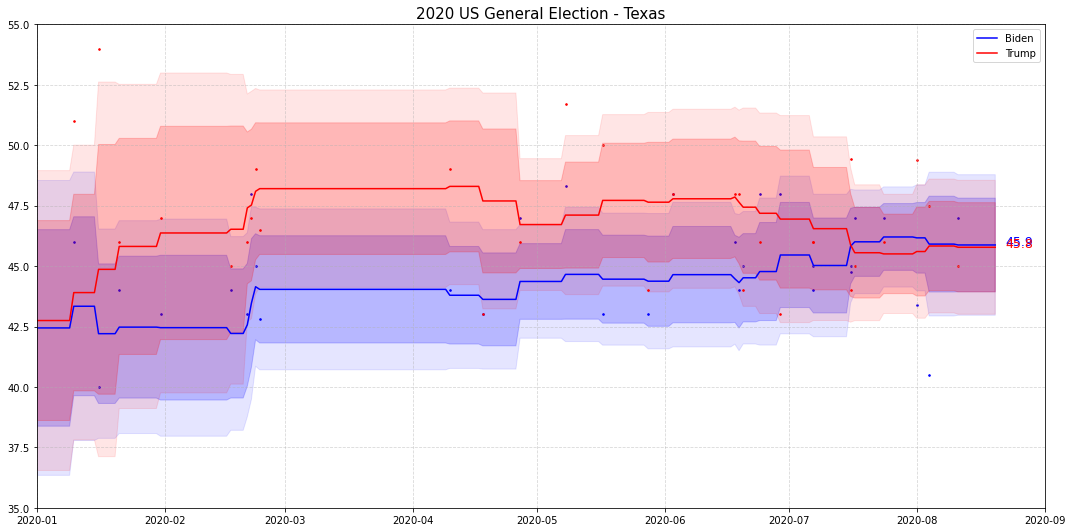

,,,,,Biden,Trump
start_date,end_date,pollster,population,sample_size,,
2020-08-11,2020-08-13,Global Strategy Group,lv,700,47.0,45.0
2020-08-04,2020-08-13,YouGov,rv,846,40.5,47.5
2020-08-01,2020-08-05,Trafalgar Group,lv,1015,43.4,49.4
2020-07-24,2020-08-02,Morning Consult,lv,2576,47.0,46.0
2020-07-17,2020-07-26,Morning Consult,lv,2685,47.0,45.0


In [33]:
get_polls_plot_atK(polls2020, 'Texas', 10, election=2020)
get_table_atK(polls2020, 'Texas', k=5)

---

---

---

# Trump Job Approval
## 3. how popular is the incumbent president?
---

In [34]:
pr_approval_polls2020 = pd.read_csv(path + '\data\processed\president_approval_polls2020.csv', 
                                    parse_dates=['start_date', 'end_date', 'created_at'], index_col=['start_date'])

In [35]:
pr_approval_polls2020.loc[pr_approval_polls2020['pollster'] == 'Rasmussen Reports/Pulse Opinion Research', 'weight'] *= 0.1

In [36]:
pr_approval_polls2020.tail()

,question_id,poll_id,state,politician,pollster_id,pollster,sample_size,population,end_date,created_at,url,approve,disapprove,population_weight,weight,diff
start_date,,,,,,,,,,,,,,,,
2020-08-16,127590,68120,National,Trump,568,YouGov,1246,rv,2020-08-18,2020-08-19 10:06:00,https://docs.cdn.yougov.com/c6n58wb53l/econTab...,43.0,54.0,0.9,1121.4,-11.0
2020-08-16,127588,68119,National,Trump,399,Rasmussen Reports/Pulse Opinion Research,1500,lv,2020-08-18,2020-08-19 09:25:00,http://www.rasmussenreports.com/public_content...,47.0,51.0,1.0,150.0,-4.0
2020-08-17,127606,68127,National,Trump,568,YouGov,801,rv,2020-08-19,2020-08-19 14:39:00,https://today.yougov.com/_pubapis/v5/us/tracke...,43.0,55.0,0.9,720.9,-12.0
2020-08-17,127618,68132,National,Trump,399,Rasmussen Reports/Pulse Opinion Research,1500,lv,2020-08-19,2020-08-20 09:24:00,http://www.rasmussenreports.com/public_content...,51.0,48.0,1.0,150.0,3.0
2020-08-18,127635,68140,National,Trump,568,YouGov,796,rv,2020-08-20,2020-08-20 13:54:00,https://today.yougov.com/_pubapis/v5/us/tracke...,42.0,55.0,0.9,716.4,-13.0


In [37]:
pr_approval_polls2020 = pr_approval_polls2020[pr_approval_polls2020['approve']+pr_approval_polls2020['disapprove'] < 100.]

In [38]:
national_pr_approval2020 = pr_approval_polls2020[pr_approval_polls2020['state'] == 'National']
national_pr_approval2020_k10 = get_state_stats_atK(pr_approval_polls2020, candidates=['approve', 'disapprove'], state='National', k=10)

In [39]:
national_pr_approval2020_k10

,approve_avg,disapprove_avg,diff_avg,approve_std,disapprove_std,diff_std
2019-06-01,44.000000,53.000000,-9.000000,NaN,NaN,NaN
2019-06-02,45.233610,52.055463,-6.821853,1.187599,1.393363,2.422499
2019-06-03,45.663209,52.098079,-6.434870,1.898299,1.851026,3.682595
2019-06-04,45.553546,52.232740,-6.679194,1.932379,1.951743,3.826103
2019-06-05,45.542456,52.311134,-6.768678,2.217156,2.054867,4.246877
...,...,...,...,...,...,...
2020-08-16,40.715982,56.083983,-15.368001,1.832143,1.837087,3.322379
2020-08-17,41.749646,55.173772,-13.424126,2.137478,1.678015,3.505626
2020-08-18,42.378600,55.194166,-12.815566,1.748342,1.772634,3.453068
2020-08-19,42.378600,55.194166,-12.815566,1.748342,1.772634,3.453068


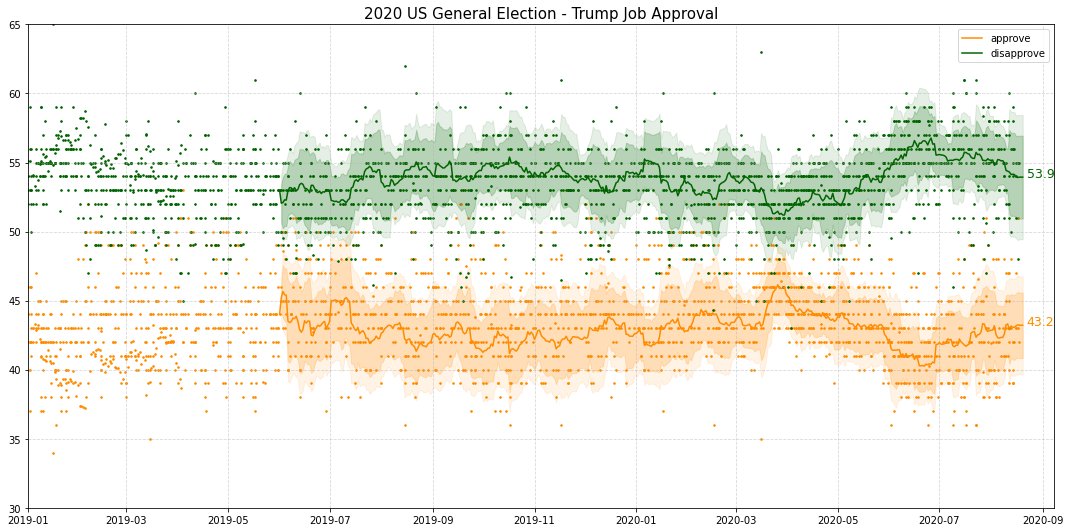

In [40]:
get_polls_plot_atK(pr_approval_polls2020, 'National', k=30, election='pr_approval')

In [41]:
get_state_stats_atK(pr_approval_polls2020, state='National', k=30, candidates=['approve', 'disapprove'])

,approve_avg,disapprove_avg,diff_avg,approve_std,disapprove_std,diff_std
2019-06-01,44.000000,53.000000,-9.000000,NaN,NaN,NaN
2019-06-02,45.233610,52.055463,-6.821853,1.187599,1.393363,2.422499
2019-06-03,45.663209,52.098079,-6.434870,1.898299,1.851026,3.682595
2019-06-04,45.424493,52.296477,-6.871984,1.899403,1.880878,3.719309
2019-06-05,45.393336,52.276787,-6.883450,1.945079,1.886646,3.772565
...,...,...,...,...,...,...
2020-08-16,43.175432,53.954919,-10.779488,2.343180,2.949056,4.445983
2020-08-17,43.248998,53.917131,-10.668133,2.390079,3.018179,4.555811
2020-08-18,43.215618,53.942328,-10.726710,2.365813,2.998760,4.517255
2020-08-19,43.215618,53.942328,-10.726710,2.365813,2.998760,4.517255


In [42]:
pr_approval_polls2020.loc['2019-12-01':'2019-12-28'].tail(35)

,question_id,poll_id,state,politician,pollster_id,pollster,sample_size,population,end_date,created_at,url,approve,disapprove,population_weight,weight,diff
start_date,,,,,,,,,,,,,,,,
2019-12-15,115131,63176,National,Trump,568,YouGov,750,rv,2019-12-17,2019-12-23 13:11:00,https://d25d2506sfb94s.cloudfront.net/cumulus_...,44.0,55.0,0.9,675.0,-11.0
2019-12-15,114978,63147,National,Trump,399,Rasmussen Reports/Pulse Opinion Research,1500,lv,2019-12-17,2019-12-18 09:35:00,http://www.rasmussenreports.com/public_content...,49.0,49.0,1.0,150.0,0.0
2019-12-16,114970,63145,National,Trump,744,Ipsos,963,rv,2019-12-17,2019-12-18 08:48:00,https://www.ipsos.com/sites/default/files/ct/n...,45.0,53.0,0.9,866.7,-8.0
2019-12-16,115133,63177,National,Trump,568,YouGov,748,rv,2019-12-18,2019-12-23 13:11:00,https://d25d2506sfb94s.cloudfront.net/cumulus_...,44.0,54.0,0.9,673.2,-10.0
2019-12-16,115079,63154,National,Trump,399,Rasmussen Reports/Pulse Opinion Research,1500,lv,2019-12-18,2019-12-19 09:31:00,http://www.rasmussenreports.com/public_content...,49.0,49.0,1.0,150.0,0.0
2019-12-17,115135,63178,National,Trump,568,YouGov,742,rv,2019-12-19,2019-12-23 13:11:00,https://d25d2506sfb94s.cloudfront.net/cumulus_...,44.0,54.0,0.9,667.8,-10.0
2019-12-17,115091,63159,National,Trump,399,Rasmussen Reports/Pulse Opinion Research,1500,lv,2019-12-19,2019-12-20 09:28:00,http://www.rasmussenreports.com/public_content...,50.0,48.0,1.0,150.0,2.0
2019-12-17,115124,63173,National,Trump,23,American Research Group,992,rv,2019-12-20,2019-12-23 10:01:00,https://americanresearchgroup.com/economy/,38.0,58.0,0.9,892.8,-20.0
2019-12-18,115152,63157,National,Trump,744,Ipsos,1108,a,2019-12-19,2019-12-23 16:50:00,https://www.ipsos.com/sites/default/files/ct/n...,42.0,52.0,0.7,775.6,-10.0


In [43]:
f.loc['2019-12']

NameError: name 'f' is not defined

In [ ]:
get_polls_plot_atK(pr_approval_polls2020, 'National', k=30, election='pr_approval')

---

---

---

# States: data visualization
---

In [ ]:
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import matplotlib.pyplot as plt

import imageio
import glob

In [ ]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

In [ ]:
proj = gcrs.AlbersEqualArea()
gplt.polyplot(
    contiguous_usa,
    zorder=-1,
    linewidth=1,
    projection=proj,
    edgecolor='black',
    facecolor='white',
    figsize=(15, 15))


plt.savefig(path+'\\reports\\figures\\US States.png', bbox_inches='tight')
plt.show()

In [ ]:
for year in ['2008', '2012', '2016']:
    proj = gcrs.AlbersEqualArea()
    scheme = mc.UserDefined(expected_electoral_college2020['result_'+year], bins=np.arange(-25, 25, 5))

    gplt.choropleth(contiguous_usa.set_index('state').join(expected_electoral_college2020), hue='result_'+year,
                    projection=proj, scheme=scheme,
                    edgecolor='black',
                    cmap='bwr_r', 
                    figsize=(15, 15))

    plt.title(year+' US Election - difference between candidates', fontsize=15)
    plt.savefig(path+'\\reports\\figures\\US States - diff_polls'+year+'.png', bbox_inches='tight')
    plt.show()

In [ ]:
proj = gcrs.AlbersEqualArea()
scheme = mc.UserDefined(expected_electoral_college2020['diff_avg'], bins=np.arange(-25, 25, 5))

gplt.choropleth(contiguous_usa.set_index('state').join(expected_electoral_college2020), hue='diff_avg',
                projection=proj, scheme=scheme,
                edgecolor='black',
                cmap='bwr_r', 
                figsize=(15, 15))

plt.title('2020 US Election - difference between candidates', fontsize=15)
plt.savefig(path+'\\reports\\figures\\US States - diff_polls2020.png', bbox_inches='tight')
plt.show()

In [ ]:
filenames = glob.glob(path+'\\reports\\figures\\US States - diff_polls*.png')


with imageio.get_writer(path+'\\reports\\figures\\US_movie.gif', mode='I', fps=0.75) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

---

---

---